# Programming for Data Science and Artificial Intelligence

## Classification - AdaBoost

## Name: Thantham Khamyai

## Student ID: 122097

### ===Task===

Your work: Let's modify the above scratch code:
- Notice that if <code>err</code> = 0, then $\alpha$ will be undefined, thus attempt to fix this by adding some very small value to the lower term
- Notice that sklearn version of AdaBoost has a parameter <code>learning_rate</code>.  This is in fact the $\frac{1}{2}$ in front of the $\alpha$ calculation.  Attempt to change this $\frac{1}{2}$ into a parameter called <code>eta</code>, and try different values of it and see whether accuracy is improved.  Note that sklearn default this value to 1.
- Observe that we are actually using sklearn DecisionTreeClassifier.  If we take a look at it closely, it is actually using weighted gini index, instead of weighted errors that we learn above.   Attempt to write your own class of <code>class Stump</code> that actually uses weighted errors, instead of weighted gini index
- Put everything into a class

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np

X, y = make_classification(n_samples=500, random_state=0)
y = np.where(y==0,-1,1)  #change our y to be -1 if it is 0, otherwise 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

Show the scatter of dataset before for imagining the dataset looks like. However, the dataset was 20 dimension features, we therefore just show it simply first and last feature combination

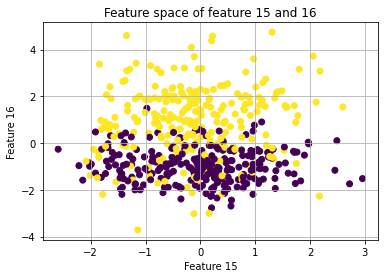

Shape of dataset:  (500, 20)


In [2]:
import matplotlib.pyplot as plt

plt.scatter(X[:,15], X[:, 16], c=y)
plt.title('Feature space of feature 15 and 16')
plt.xlabel('Feature 15')
plt.ylabel('Feature 16')
plt.grid()
plt.show()


print('Shape of dataset: ',X.shape)

### TASK 3: Stump class

Actually, we have to put stump class may be into inner class, but we personally have separated class called **StumpClassifier** to further use separately for different appraoch.

This is also make the **Adaboost** class being more feasible to be used for different kinds of classifier

In [3]:
class StumpClassifier:
        
    def __init__(self):
        self.polarity = 1
        self.feature_index = None
        self.threshold = None
        
    def fit(self, X, y, sample_weight=None):
        
        self.min_err = np.inf
        m,n = X.shape
        
        if sample_weight is None:
            sample_weight = np.full(m, 1/m)
        # # init equal weight
        
        for feature in range(n): # looping for all features
            
                feature_vals = np.sort(np.unique(X[:, feature])) # get sorted features
                thresholds = (feature_vals[:-1] + feature_vals[1:])/2 # get all of thresholds in features
                
                for threshold in thresholds: # looping for each threshold
                    
                    for polarity in [1, -1]: # check for polarity twice
                        
                        yhat = np.ones(len(y)) # init all answers as 1
                        
                        # change the answer into -1 if the feature value that less than threshold in current polarity
                        yhat[polarity * X[:, feature] < polarity * threshold] = -1
                        
                        # evaluate error
                        err = sample_weight[(yhat != y)].sum()
    
                        # if error is less than before -> define current feature_idx and threshold of splitting
                        if err < self.min_err:
                            self.polarity = polarity
                            self.threshold = threshold
                            self.feature_index = feature
                            self.min_err = err
                            
                # if further feature splitting gives more less of error -> define that feature for feature split
        
        
    def predict(self, X):
        m, n = X.shape

        pred = np.ones(m) # init all answer as 1
        
        # change the answer into -1 if the feature value that less than threshold in current polarity
        pred[self.polarity * X[:,self.feature_index] < self.polarity * self.threshold] = -1

        return pred # return sign of the answer

### TASK 4: Put every thing into a class (Include task 1)

I made this class similar to the way of sklearn do. we can put any classifier into the this class.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

class AdaBoost:
    
    def __init__(self, estimator = None, n_estimators=20, model_params={}, eta=0.5):
        
        self.n_estimators = n_estimators
        self.model_params = model_params
        self.eps = 1e-10 # < ======== TASK 1: Epsilon
        self.eta = eta # < ======================= TASK 2: Adding learning rate (ETA)
        if estimator == None:
            raise ValueError('No Classifier Implemented')
        # init estimator classifiers set following the predefined params
        self.models = [estimator(**self.model_params) for _ in range(self.n_estimators)]
        
    
    def fit(self, X_train, y_train):
        
        m, n = X_train.shape
        
        self.W = np.full(m, 1/m) # init weak learner weights of samples
        self.err = np.zeros(self.n_estimators)
        self.alpha = np.zeros(self.n_estimators) # init alpha of each classifier
        
        for i, model in enumerate(self.models): # looping each model in modelset
            
            #if model == StumpClassifier or model == DecisionTreeClassifier:
            model.fit(X_train, y_train, sample_weight= self.W) # simply fit
           #else:
               # model.fit(X_train, y_train) # simply fit
                
            yhat = model.predict(X_train) #simply predict
        
            self.err[i] = np.sum(self.W[(y_train != yhat)])# evaluate error of current model
            
            # calculate alpha (voting power) of current model
            self.alpha[i] = np.log ((1 - self.err[i]) / (self.err[i] + self.eps)) * self.eta

            # calculate Weaker learner weights of each samples
            self.W = (self.W * np.exp(-1 * self.alpha[i] * y_train * yhat)) 
            self.W = self.W / sum (self.W)
                
    
    def predict(self, X_test):
        
        H_X = 0
        
        for i, model in enumerate(self.models):  # looping for each model in modelset  

            yhat = model.predict(X_test) # simply predict
            H_X += self.alpha[i] * yhat # weight the answers
        
        return np.sign(H_X) # just give the sign of answers
    

To show up the model class, I put **StumpClassifier** for estimator and keep it default number of estimators

In [5]:
model = AdaBoost(estimator=StumpClassifier, n_estimators=10, model_params={}, eta=0.5)
model.fit(X_train, y_train)
model.alpha

array([0.81856067, 0.29475976, 0.41235906, 0.34117456, 0.30285599,
       0.32122678, 0.33368036, 0.25361927, 0.24045749, 0.25307535])

As we known, lets predict the result of training

In [6]:
y_pred = model.predict(X_test)

The result is also being the same as set of {-1,+1} following therotical

In [7]:
y_pred[:20]

array([ 1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        1., -1.,  1.,  1., -1.,  1.,  1.])

Finally, examine the classification report

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.78      0.85      0.82        73
           1       0.85      0.78      0.81        77

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.82      0.81      0.81       150



### Try different <code>eta</code> (Task 2)

In [9]:
model = AdaBoost(estimator=StumpClassifier, n_estimators=10, model_params={}, eta=0.01)
model.fit(X_train, y_train)

print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.79      0.85      0.82        73
           1       0.85      0.79      0.82        77

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



In [10]:
model.alpha

array([0.01637121, 0.01605737, 0.01573622, 0.01547564, 0.0152153 ,
       0.01495051, 0.01469849, 0.01451242, 0.01426257, 0.01404501])

#### Discussion of  <code>eta</code>: 

The implementation of different <code>eta</code> is mainly focused on the change of alpha in each model. The much more  <code>eta</code> indicates that there will be a huge change through the adjustment of alpha among Weak Learner weights.

When we use the every less  <code>eta</code>, it will be giving small differences of voting power in each model. However, the big difference in term of accuracy is very difficult to indicate due to the adjustment of weak learner sample weights after a few further models.

Therefore, big  <code>eta</code> will give the overshooting of alpha and weak learner weights adjustment. the small  <code>eta</code> will indicate small change between voting power of each submodel. So, we have to consider this and choose the balanced  <code>eta</code> to reach optimal alpha of each model

#### StumpClassifier Usage

For show up the usage of Stump classifier

In [11]:
stump = StumpClassifier()
stump.fit(X_train, y_train)
print(classification_report(y_test, stump.predict(X_test)))

print('Feature to split: ', stump.feature_index)
print('Feature threshold: ', stump.threshold)
print('Min error: ', stump.min_err)

              precision    recall  f1-score   support

          -1       0.79      0.84      0.81        73
           1       0.84      0.79      0.81        77

    accuracy                           0.81       150
   macro avg       0.81      0.81      0.81       150
weighted avg       0.81      0.81      0.81       150

Feature to split:  16
Feature threshold:  -0.2323816980491494
Min error:  0.16285714285714287
